# **Question Answering with the SQuAD 2.0 Dataset**

This notebook demonstrates the implementation of an extractive question-answering Transformer network model using the [Stanford Question Answering Dataset (SQuAD) 2.0](https://huggingface.co/datasets/rajpurkar/squad_v2), a more challenging dataset than [SQuAD](https://github.com/JersonGB22/QuestionAnswering-TensorFlow/tree/main/Models_AnsweredQuestions/ExtractiveQA_RoBERTa_SQuAD.ipynb), because it includes questions that do not have an answer. This requires the model not only to answer questions when possible but also to determine when the context does not support any answer and refrain from responding. For this task, the [RoBERTa (Robustly Optimized BERT Pretraining Approach)](https://huggingface.co/docs/transformers/en/model_doc/roberta) model from [Hugging Face 🤗](https://huggingface.co/) is fine-tuned to improve its performance.

Hugging Face is a platform focused on developing tools and models for natural language processing (NLP). It is known for its open-source library called Transformers, which provides an easy-to-use interface for working with advanced pre-trained NLP models such as BERT, T5, GPT, and others.

**Key Points:**
- **Model Architecture:** The RoBERTa Large model from Hugging Face is used, which is based on [BERT](https://huggingface.co/docs/transformers/en/model_doc/bert) but achieves better results on GLUE, RACE, and SQuAD, datasets used to evaluate reasoning and text comprehension models. The model is loaded using the generic class [TFAutoModelForQuestionAnswering](https://huggingface.co/transformers/v3.0.2/model_doc/auto.html#transformers.TFAutoModelForQuestionAnswering), which allows creating an instance of a pre-trained model based on TensorFlow, specifically designed for question answering tasks, as it includes an appropriate classification layer on top. This differs from [TFAutoModel](https://huggingface.co/transformers/v3.0.2/model_doc/auto.html#tfautomodel), which provides the base model without additional layers.

- **Tokenization:** Hugging Face has implemented a tokenizer for each of its models that returns everything needed for the respective model's inputs. In this case, the generic tokenizer [AutoTokenizer](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoTokenizer) will be used, which allows creating an instance of the model's tokenizer by its name alone. For this Question Answering task, the question and context are passed to the tokenizer to return `input_ids` (the tokenized sequences) and `attention_mask` (a mask to avoid attending to padding token indices). Additionally, the tokenizer must return `offset_mapping`, which are the start and end positions of each token in the original text ('question' and 'context'), and `sequence_ids`, which are the ids of each part of the sequence; these are necessary to find the start and end tokens of the answers in `input_ids`. Lastly, only sequences with a length less than or equal to 512, which is the maximum length allowed by the RoBERTa tokenizer, are considered. In case sequences longer than this are introduced after training, the context is truncated and not the question, using the `only_second` argument.

- **Use of TPU:** Due to the enormous size of the RoBERTa model, specifically "roberta-large", which has over 300 million parameters, using the TPU in Google Colab is necessary to significantly accelerate training. Although only the parameters of the classification layer are adjusted, loading and processing pre-trained embeddings along with intensive backpropagation calculations require considerable computational resources. The TPU facilitates efficient handling of these tasks compared to GPUs or CPUs, optimizing performance and training time.

## **Imports**

In [ ]:
!pip install datasets -q

In [ ]:
import tensorflow as tf
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"

from transformers import TFAutoModelForQuestionAnswering, AutoTokenizer
from datasets import load_dataset, load_from_disk, load_metric
import numpy as np
import plotly.graph_objects as go
from google.colab import drive
from IPython.core.display import HTML
from IPython.display import clear_output
import textwrap
from tqdm.auto import tqdm

## **Parameters**

In [ ]:
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
epochs = 10
batch_size = 64
buffer_size = 1024
max_length = 512
AUTOTUNE = tf.data.AUTOTUNE
SEED = 123

model_name = "roberta-large"
train_filename = "/content/drive/MyDrive/Datasets/train_qa_roberta_squad_v2.tfrecord"
val_filename = "/content/drive/MyDrive/Datasets/val_qa_roberta_squad_v2.tfrecord"

## **Preprocessing and Saving Data in TFRecord Format**

Since SQuAD 2.0 is large and the RoBERTa Large model is also substantial, the data is preprocessed, tokenized, and saved in TFRecord format, which allows for truly massive data pipeline performance for training on Colab's TPU. This is now more accessible as it is no longer necessary to store the TFRecord files in Google Cloud Storage due to the new version of Colab's TPU, ``TPU v2``, which has [transitioned from TPU Node to TPU VM](https://github.com/googlecolab/colabtools/issues/4481).

### **Load and Preprocess the Dataset**

In [ ]:
train_dataset, val_dataset = load_dataset("squad_v2", split=["train", "validation"])

print(train_dataset)
val_dataset

Dataset({
    features: ['id', 'title', 'context', 'question', 'answers'],
    num_rows: 130319
})


Dataset({
    features: ['id', 'title', 'context', 'question', 'answers'],
    num_rows: 11873
})

In [ ]:
# See an example of the training dataset
train_dataset[0]

{'id': '56be85543aeaaa14008c9063',
 'title': 'Beyoncé',
 'context': 'Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny\'s Child. Managed by her father, Mathew Knowles, the group became one of the world\'s best-selling girl groups of all time. Their hiatus saw the release of Beyoncé\'s debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".',
 'question': 'When did Beyonce start becoming popular?',
 'answers': {'text': ['in the late 1990s'], 'answer_start': [269]}}

**Import the AutoTokenizer**

In [ ]:
# 'use_fast=True': improves the tokenizer's performance when processing large volumes of text

tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
tokenizer

RobertaTokenizerFast(name_or_path='roberta-large', vocab_size=50265, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	50264: AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False, special=True),
}

In [ ]:
# Example of tokenization

id = 30000
example = train_dataset[id]
print("Question:\n", example["question"], "\n")
print("Context:\n", textwrap.fill(example["context"], width=100), "\n")

encoding = tokenizer(
    example["question"],
    example["context"],
    padding="max_length",
    max_length=80,
    return_offsets_mapping=True
)

input_ids = encoding["input_ids"]
print("Input Ids:\n", input_ids, "\n")
print("Tokens:\n", tokenizer.convert_ids_to_tokens(input_ids), "\n")
print("Decoded Text without Special Tokens:\n", tokenizer.decode(input_ids, skip_special_tokens=True), "\n\n")

offsets = encoding["offset_mapping"]
print("Start and end position of each token in each original text ('question' and 'context'):\n", offsets, "\n")
sequence_ids = encoding.sequence_ids()
print("Sequence IDs:\n", sequence_ids, "\n\n")

start_char = example["answers"]["answer_start"][0]
end_char = start_char + len(example["answers"]["text"][0])
token_start_index, token_end_index = 0, len(input_ids) - 1

# Find the position of the first and last tokens corresponding to the answer, aligned with 'input_ids'
while sequence_ids[token_start_index] != 1:
  token_start_index += 1
while sequence_ids[token_end_index] != 1:
  token_end_index -= 1

while offsets[token_start_index][0] <= start_char:
  token_start_index += 1
token_start_index -= 1
while offsets[token_end_index][1] >= end_char:
  token_end_index -= 1
token_end_index += 1

print("Answer:\n", example["answers"]["text"][0], "\n")
print("Indices of the Start and End Tokens of the Answer:\n", token_start_index, token_end_index, "\n")
print("Tokenized Answer:\n", input_ids[token_start_index: token_end_index+1], "\n")
print("Decoded Answer:\n", tokenizer.decode(input_ids[token_start_index: token_end_index+1]), "\n\n")

print("Attention Mask:\n", encoding["attention_mask"])

Question:
 What year did the lawsuits end? 

Context:
 In February 2007, Texas MP3 Technologies sued Apple, Samsung Electronics and Sandisk in eastern
Texas federal court, claiming infringement of a portable MP3 player patent that Texas MP3 said it
had been assigned. Apple, Samsung, and Sandisk all settled the claims against them in January 2009. 

Input Ids:
 [0, 2264, 76, 222, 5, 8986, 253, 116, 2, 2, 1121, 902, 3010, 6, 1184, 3957, 246, 5974, 8124, 1257, 6, 3797, 12057, 8, 4219, 6812, 11, 4580, 1184, 752, 461, 6, 4564, 26461, 9, 10, 15295, 3957, 246, 869, 11354, 14, 1184, 3957, 246, 26, 24, 56, 57, 5530, 4, 1257, 6, 3797, 6, 8, 4219, 6812, 70, 5668, 5, 1449, 136, 106, 11, 644, 2338, 4, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] 

Tokens:
 ['<s>', 'What', 'Ġyear', 'Ġdid', 'Ġthe', 'Ġlawsuits', 'Ġend', '?', '</s>', '</s>', 'In', 'ĠFebruary', 'Ġ2007', ',', 'ĠTexas', 'ĠMP', '3', 'ĠTechnologies', 'Ġsued', 'ĠApple', ',', 'ĠSamsung', 'ĠElectronics', 'Ġand', 'ĠSand', 'isk', 'Ġin', 'Ġeastern', 'ĠTex

**Filter the datasets to consider only sequences less than or equal to 512**

In [ ]:
def filter_datasets(example):
  encoding = tokenizer(example["question"], example["context"])
  return len(encoding["input_ids"]) <= max_length

train_dataset = train_dataset.filter(filter_datasets)
val_dataset = val_dataset.filter(filter_datasets)

len(train_dataset), len(val_dataset)

Filter:   0%|          | 0/11873 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (588 > 512). Running this sequence through the model will result in indexing errors


(130101, 11791)

In [ ]:
print(130319 - len(train_dataset), 11873 - len(val_dataset))
218/87599, 82/10570

218 82


(0.002488612883708718, 0.007757805108798486)

It is observed that the discarded sequences are not even 0.8% of the datasets.

**Tokenization**

In [ ]:
def preprocessing(examples):
  tokenized_examples = tokenizer(
        examples["question"],
        examples["context"],
        padding="max_length",
        max_length=max_length,
        truncation="only_second",
        return_offsets_mapping=True
  )

  offset_mapping = tokenized_examples["offset_mapping"]
  tokenized_examples["start_position"] = []
  tokenized_examples["end_position"] = []

  for i, offsets in enumerate(offset_mapping):
    # When a question has no answer, consider both the start and end positions to be the 'cls_token' (0)
    if len(examples["answers"][i]["text"]) == 0:
      tokenized_examples["start_position"].append(0)
      tokenized_examples["end_position"].append(0)

    else:
      input_ids = tokenized_examples["input_ids"][i]
      sequence_ids = tokenized_examples.sequence_ids(i)
      answers = examples["answers"][i]

      start_char = answers["answer_start"][0]
      end_char = start_char + len(answers["text"][0])
      token_start_index, token_end_index = 0, len(input_ids) - 1

      while sequence_ids[token_start_index] != 1:
        token_start_index += 1
      while sequence_ids[token_end_index] != 1:
        token_end_index -= 1

      while (token_start_index < len(input_ids)) and (offsets[token_start_index][0]) <= start_char:
        token_start_index += 1
      while offsets[token_end_index][1] >= end_char:
        token_end_index -= 1

      tokenized_examples["start_position"].append(token_start_index - 1)
      tokenized_examples["end_position"].append(token_end_index + 1)

  return tokenized_examples

In [ ]:
train_dataset = train_dataset.map(preprocessing, batched=True, remove_columns=train_dataset.column_names)
val_dataset = val_dataset.map(preprocessing, batched=True, remove_columns=["title"])

Map:   0%|          | 0/130101 [00:00<?, ? examples/s]

Map:   0%|          | 0/11791 [00:00<?, ? examples/s]

In [ ]:
# Save the evaluation dataset for the Evaluation and Predictions section
val_dataset.save_to_disk("/content/drive/MyDrive/Datasets/val_dataset_squad_v2_roberta")

Saving the dataset (0/1 shards):   0%|          | 0/11791 [00:00<?, ? examples/s]

### **Saving Data in TFRecord Format**

In [ ]:
def save_tfrecord(filename, dataset):
  with tf.io.TFRecordWriter(filename) as writer:
    for dic in tqdm(dataset):
      features = {
          "input_ids": tf.train.Feature(int64_list=tf.train.Int64List(value=dic["input_ids"])),
          "attention_mask": tf.train.Feature(int64_list=tf.train.Int64List(value=dic["attention_mask"])),
          "start_position": tf.train.Feature(int64_list=tf.train.Int64List(value=[dic["start_position"]])),
          "end_position": tf.train.Feature(int64_list=tf.train.Int64List(value=[dic["end_position"]]))
      }

      features = tf.train.Features(feature=features)
      example = tf.train.Example(features=features).SerializeToString()
      writer.write(example)

In [ ]:
save_tfrecord(train_filename, train_dataset)
save_tfrecord(val_filename, val_dataset)

  0%|          | 0/130101 [00:00<?, ?it/s]

  0%|          | 0/11791 [00:00<?, ?it/s]

## **Using the TPU for Training**

From this point onward until **Predictions with the Trained Model**, the use of TPU is mandatory, as each epoch takes approximately 24 minutes to complete even with its utilization.

In [ ]:
# TPU setup
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu="local")
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.TPUStrategy(tpu)
  print("TPU initialized:")
  print("All devices: ", tf.config.list_logical_devices("TPU"))
except ValueError:
  print("TPU not found")

TPU initialized:
All devices:  [LogicalDevice(name='/device:TPU:0', device_type='TPU'), LogicalDevice(name='/device:TPU:1', device_type='TPU'), LogicalDevice(name='/device:TPU:2', device_type='TPU'), LogicalDevice(name='/device:TPU:3', device_type='TPU'), LogicalDevice(name='/device:TPU:4', device_type='TPU'), LogicalDevice(name='/device:TPU:5', device_type='TPU'), LogicalDevice(name='/device:TPU:6', device_type='TPU'), LogicalDevice(name='/device:TPU:7', device_type='TPU')]


### **Loading the Preprocessed Datasets**

In [ ]:
train_size, val_size = 130101, 11791

In [ ]:
def decode_tfrecord(sample):
  input_features = {
      "input_ids": tf.io.FixedLenFeature((max_length, ), tf.int64),
      "attention_mask": tf.io.FixedLenFeature((max_length, ), tf.int64)
  }

  output_features = {
      "start_position": tf.io.FixedLenFeature((), tf.int64),
      "end_position": tf.io.FixedLenFeature((), tf.int64),
  }

  input_parsed_features = tf.io.parse_example(sample, input_features)
  output_parsed_features = tf.io.parse_example(sample, output_features)
  return input_parsed_features, output_parsed_features


def load_dataset(filename, size, shuffle=True):
  dataset = tf.data.TFRecordDataset(filename)
  dataset = dataset.map(decode_tfrecord, num_parallel_calls=AUTOTUNE)
  dataset = dataset.apply(tf.data.experimental.assert_cardinality(size))

  if shuffle:
    dataset = dataset.shuffle(buffer_size, seed=SEED)
  dataset = dataset.batch(batch_size).prefetch(AUTOTUNE)

  return dataset

In [ ]:
train_dataset = load_dataset(train_filename, train_size)
val_dataset = load_dataset(val_filename, val_size, shuffle=False)

In [ ]:
# Viewing a training batch
for inputs, outputs in train_dataset.take(1):
  print(inputs["input_ids"], "\n")
  print(inputs["attention_mask"], "\n")
  print(outputs["start_position"], "\n")
  print(outputs["end_position"])

tf.Tensor(
[[    0  3908  3309 ...     1     1     1]
 [    0  6179   171 ...     1     1     1]
 [    0 12375  2312 ...     1     1     1]
 ...
 [    0  7608   222 ...     1     1     1]
 [    0  2264    76 ...     1     1     1]
 [    0  2264   183 ...     1     1     1]], shape=(64, 512), dtype=int64) 

tf.Tensor(
[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]], shape=(64, 512), dtype=int64) 

tf.Tensor(
[ 73 102 110  61  72 110  57  23  20  66  14 168  33 215 101 141  68 125
  45  23 152  57  23 137 126  56  59  68  95  63 125  73  95  21  98 201
  88  28  49 175  16 118  87 102  73 265  61 101 141  21  23  21 128 106
 195 118 194  35  60  94  30 135  96  15], shape=(64,), dtype=int64) 

tf.Tensor(
[ 79 103 113  62  73 113  57  24  22  66  15 168  45 215 102 159  70 126
  46  23 158  65  24 139 129  62  60  74  97  71 126  76  97  22  99 213
  91  30  50 175  17 125  92 108  73 265  62 102 144  21  26  23 129 1

### **Creation and Training of the Model**


Due to this model using two outputs representing the start and end positions of answer tokens, two identical losses of [``tf.keras.losses.SparseCategoricalCrossentropy``](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy) are employed. Since the outputs from the base RoBERTa model have not yet undergone the ``argmax`` operation, it is necessary to set the ``from_logits=True`` argument. As an optimizer, [``tf.keras.optimizers.AdamW``](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/AdamW) is utilized, known for its computational efficiency, low memory requirements, invariance to diagonal gradient scaling changes, and suitability for large-scale data/parameter problems typical of Transformers models. It is employed with ``weight_decay=0.01`` to regularize the model weights and enhance generalization.

Although conventional ``accuracy`` is not ideal for evaluating this model, it serves as a useful approximation to monitor its performance. Therefore, two callbacks are used to monitor these metrics on the evaluation set to mitigate overfitting. Later, the model will be evaluated using official SQuAD 2.0 metrics.

In [ ]:
callback_start = tf.keras.callbacks.EarlyStopping(
    monitor="val_start_position_accuracy",
    patience=2,
    mode="max",
    restore_best_weights=True
)

callback_end = tf.keras.callbacks.EarlyStopping(
    monitor="val_end_position_accuracy",
    patience=2,
    mode="max",
    restore_best_weights=True
)

In [ ]:
def create_model():
  # Import the AutoModel
  model_base = TFAutoModelForQuestionAnswering.from_pretrained(model_name)

  input_ids = tf.keras.Input((max_length, ), dtype=tf.int64, name="input_ids")
  attention_mask = tf.keras.Input((max_length, ), dtype=tf.int64, name="attention_mask")
  logits = model_base(input_ids=input_ids, attention_mask=attention_mask)

  # Activation layers do not alter the outputs; they only serve to rename them (linear: x=y)
  start_logits = tf.keras.layers.Activation("linear", name="start_position")(logits.start_logits)
  end_logits = tf.keras.layers.Activation("linear", name="end_position")(logits.end_logits)

  model = tf.keras.Model(
      inputs=[input_ids, attention_mask],
      outputs=[start_logits, end_logits]
  )

  return model

In [ ]:
tf.keras.backend.clear_session() #Clearing Keras memory
tf.random.set_seed(123) #For reproducibility

# Creation and compilation of the model within the distribution strategy
with strategy.scope():
  model = create_model()

  loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  model.compile(
      optimizer=tf.keras.optimizers.AdamW(learning_rate=2e-5, weight_decay=0.01),
      loss={"start_position": loss_fn, "end_position": loss_fn},
      metrics={"start_position": "accuracy", "end_position": "accuracy"},
      steps_per_execution=200
  )

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForQuestionAnswering: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForQuestionAnswering from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForQuestionAnswering from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForQuestionAnswering were not initialized from the PyTorch model and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 512)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 512)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_roberta_for_question_an  TFQuestionAnsweringModelOu   3543121   ['input_ids[0][0]',           
 swering (TFRobertaForQuest  tput(loss=None, start_logi   94         'attention_mask[0][0]']      
 ionAnswering)               ts=(None, 512),                                                  

In [ ]:
tf.random.set_seed(SEED)
history = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=[callback_start, callback_end])

Epoch 1/10
2033/2033 [==============================] - 1707s 840ms/step - loss: 1.8700 - start_position_loss: 0.9673 - end_position_loss: 0.9027 - start_position_accuracy: 0.7090 - end_position_accuracy: 0.7347 - val_loss: 1.5073 - val_start_position_loss: 0.7661 - val_end_position_loss: 0.7412 - val_start_position_accuracy: 0.7623 - val_end_position_accuracy: 0.7733
Epoch 2/10
2033/2033 [==============================] - 1376s 677ms/step - loss: 1.2565 - start_position_loss: 0.6581 - end_position_loss: 0.5984 - start_position_accuracy: 0.7883 - end_position_accuracy: 0.8159 - val_loss: 1.5057 - val_start_position_loss: 0.7660 - val_end_position_loss: 0.7397 - val_start_position_accuracy: 0.7781 - val_end_position_accuracy: 0.7913
Epoch 3/10
2033/2033 [==============================] - 1376s 677ms/step - loss: 1.0521 - start_position_loss: 0.5517 - end_position_loss: 0.5004 - start_position_accuracy: 0.8183 - end_position_accuracy: 0.8430 - val_loss: 1.5371 - val_start_position_loss: 

### **Save model**

In [ ]:
trained_model_path = "/content/drive/MyDrive/models/ExtractiveQA_RoBERTa_SQuAD_v2"

In [ ]:
model.layers[2].save_pretrained(trained_model_path)

## **Model Evaluation**

### **With conventional Accuracy**

In [ ]:
print(model.evaluate(train_dataset, verbose=0))
print(model.evaluate(val_dataset, verbose=0))

[0.8293669819831848, 0.4320789575576782, 0.39728668332099915, 0.8510311245918274, 0.8782330751419067]
[1.5371326208114624, 0.7560956478118896, 0.7810367941856384, 0.7890763878822327, 0.7990840673446655]


In [ ]:
# Function to plot the metrics
def plot_metrics(history=history, metric="loss", renderer=None, epochs=len(history.history["loss"])):
  losses = history.history[metric]
  val_losses = history.history[f"val_{metric}"]
  list_epochs = np.arange(1, epochs+1)
  metric = " ".join([w.capitalize() for w in metric.split("_")])

  fig=go.Figure()
  fig.add_trace(go.Scatter(x=list_epochs, y=losses, name=metric, line=dict(color="blue", width=2)))
  fig.add_trace(go.Scatter(x=list_epochs, y=val_losses, name=f"Val {metric}", line=dict(color="#FF6600", width=2)))
  fig.update_xaxes(title_text="Epoch")
  fig.update_yaxes(title_text=metric)
  fig.update_layout(title=f"Evolution of {metric} across Epochs",
                    title_font=dict(size=20),
                    title_x=0.5,
                    height=500,
                    width=1200)

  fig.show(renderer)

**Interactive graphics**

In [ ]:
plot_metrics()
plot_metrics(metric="start_position_accuracy")
plot_metrics(metric="end_position_accuracy")

**Images for GitHub**

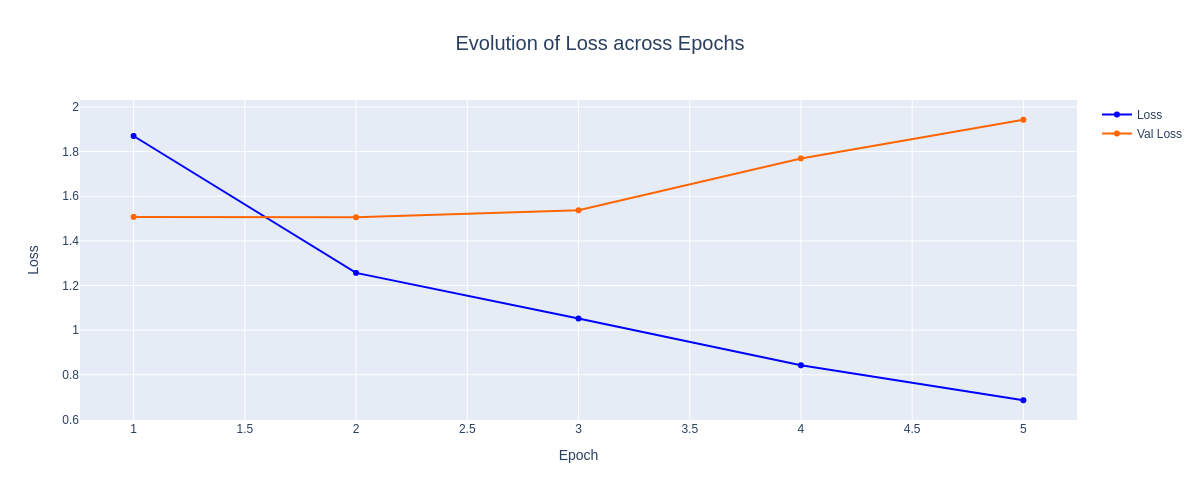

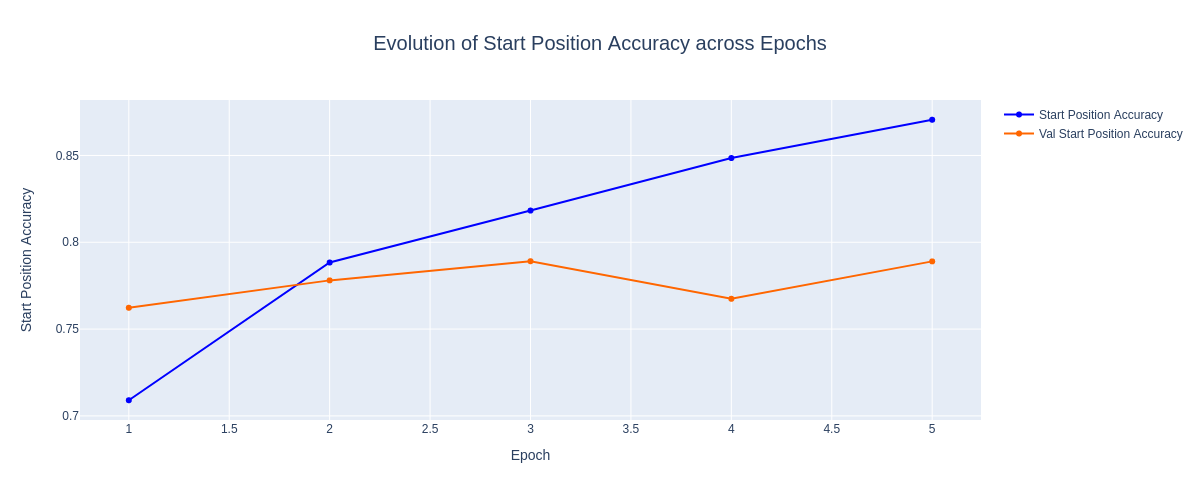

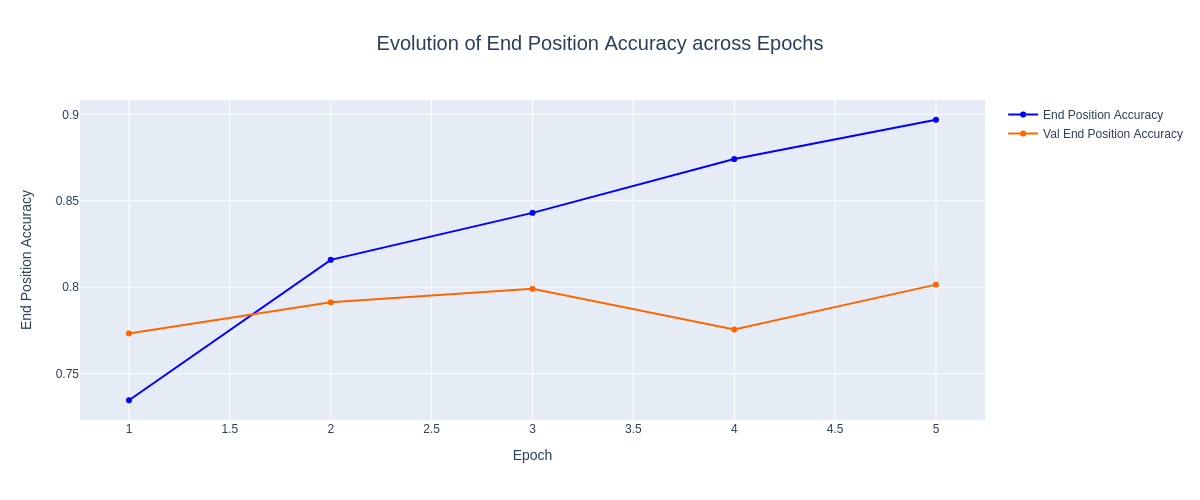

In [ ]:
plot_metrics(renderer="png")
plot_metrics(metric="start_position_accuracy", renderer="png")
plot_metrics(metric="end_position_accuracy", renderer="png")

### **With the official metrics for SQuAD_v2**

In [ ]:
# Calculate the logits and load the saved evaluation dataset

logits = model.predict(val_dataset)
val_dataset_eval = load_from_disk("/content/drive/MyDrive/Datasets/val_dataset_squad_v2_roberta")
n_best_size = 10

185/185 [==============================] - 112s 608ms/step


**Function to predict answers accurately for evaluation**

In [ ]:
def find_predictions(start_logits, end_logits, input_ids, offset, context, n_best_size):
  # Find the top n indices for start and end positions for the answers
  start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1]
  end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1]

  valid_indexes = []
  # Find all indices of separation tokens in 'input_ids'
  sep_indexes = [i for i, index in enumerate(input_ids) if index == tokenizer.sep_token_id]

  for start_index in start_indexes:
    for end_index in end_indexes:
      # Consider only valid answers that are found within the context
      condition = (start_index <= end_index) and (start_index > sep_indexes[1]) and (end_index < sep_indexes[2])

      # Also, consider only the answers that have the start and end token as 0
      if (start_index == 0 and end_index == 0) or condition:
        start_char = offset[start_index][0]
        end_char = offset[end_index][1]

        valid_indexes.append({
            "score": start_logits[start_index] + end_logits[end_index],
            "predicted_answer": context[start_char: end_char],
            "start_position": start_char,
            "end_position": end_char
        })

  if len(valid_indexes) > 0:
    valid_indexes = sorted(valid_indexes, key=lambda x: x["score"], reverse=True)[:n_best_size]
  else:
    # Edge case where there are no valid answers within the top n logits
    valid_indexes = [{
        "score": 0.0,
        "predicted_answer": "",
        "start_position": 0,
        "end_position": 0
    }]

  return valid_indexes

**Prediction Examples**

In [ ]:
# Answered question
id = 0
preds = find_predictions(
    logits[0][id],
    logits[1][id],
    val_dataset_eval["input_ids"][id],
    val_dataset_eval["offset_mapping"][id],
    val_dataset_eval["context"][id],
    n_best_size=5
)

print("Context:\n", textwrap.fill(val_dataset_eval["context"][id], width=100), "\n")
print("Question:\n", val_dataset_eval["question"][id], "\n")
print("Prediction:\n", preds, "\n")

print(f'Answers:\n{val_dataset_eval["answers"][id]["text"]}')

Context:
 The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th
and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse
("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway who, under
their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations
of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants
would gradually merge with the Carolingian-based cultures of West Francia. The distinct cultural and
ethnic identity of the Normans emerged initially in the first half of the 10th century, and it
continued to evolve over the succeeding centuries. 

Question:
 In what country is Normandy located? 

Prediction:
 [{'score': 11.674754, 'predicted_answer': 'France', 'start_position': 159, 'end_position': 165}, {'score': 3.3062587, 'predicted_answer': 'in France', 'start_position': 156, 'end_pos

In [ ]:
# Unanswered question
id = 101
preds = find_predictions(
    logits[0][id],
    logits[1][id],
    val_dataset_eval["input_ids"][id],
    val_dataset_eval["offset_mapping"][id],
    val_dataset_eval["context"][id],
    n_best_size=5
)

print("Context:\n", textwrap.fill(val_dataset_eval["context"][id], width=100), "\n")
print("Question:\n", val_dataset_eval["question"][id], "\n")
print("Prediction:\n", preds, "\n")

print(f'Answers:\n{val_dataset_eval["answers"][id]["text"]}')

Context:
 In 1066, Duke William II of Normandy conquered England killing King Harold II at the Battle of
Hastings. The invading Normans and their descendants replaced the Anglo-Saxons as the ruling class
of England. The nobility of England were part of a single Normans culture and many had lands on both
sides of the channel. Early Norman kings of England, as Dukes of Normandy, owed homage to the King
of France for their land on the continent. They considered England to be their most important
holding (it brought with it the title of King—an important status symbol). 

Question:
 Who replaced the Normans as the ruling class? 

Prediction:
 [{'score': 9.741699, 'predicted_answer': '', 'start_position': 0, 'end_position': 0}, {'score': -3.2834597, 'predicted_answer': 'Anglo-Saxons', 'start_position': 161, 'end_position': 173}, {'score': -4.9151425, 'predicted_answer': 'the Anglo-Saxons', 'start_position': 157, 'end_position': 173}, {'score': -6.973183, 'predicted_answer': 'Normans and the

**Prepare the evaluation dataset to calculate the SQuAD 2.0 metrics**

In [ ]:
def prepare_for_evaluation(logits, dataset, n_best_size=n_best_size):
  start_logits = logits[0]
  end_logits = logits[1]

  input_ids = dataset["input_ids"]
  offsets = dataset["offset_mapping"]
  contexts = dataset["context"]
  answers = dataset["answers"]
  ids = dataset["id"]

  predictions, references = [], []

  for i in tqdm(range(len(dataset))):
    prediction = find_predictions(
        start_logits[i],
        end_logits[i],
        input_ids[i],
        offsets[i],
        contexts[i],
        n_best_size=n_best_size
    )[0]

    predictions.append({
        "prediction_text": prediction["predicted_answer"],
        "id": ids[i],
        "no_answer_probability": 0. #This is already included in the score, so they are all 0.0
    })

    references.append({
        "answers": answers[i],
        "id": ids[i]
    })

  return predictions, references

In [ ]:
predictions, references = prepare_for_evaluation(logits, val_dataset_eval)

  0%|          | 0/11791 [00:00<?, ?it/s]

In [ ]:
# Load the evaluation metric
metric = load_metric("squad_v2")
metric

Metric(name: "squad_v2", features: {'predictions': {'id': Value(dtype='string', id=None), 'prediction_text': Value(dtype='string', id=None), 'no_answer_probability': Value(dtype='float32', id=None)}, 'references': {'id': Value(dtype='string', id=None), 'answers': Sequence(feature={'text': Value(dtype='string', id=None), 'answer_start': Value(dtype='int32', id=None)}, length=-1, id=None)}}, usage: """
Computes SQuAD v2 scores (F1 and EM).
Args:
    predictions: List of triple for question-answers to score with the following elements:
        - the question-answer 'id' field as given in the references (see below)
        - the text of the answer
        - the probability that the question has no answer
    references: List of question-answers dictionaries with the following key-values:
            - 'id': id of the question-answer pair (see above),
            - 'answers': a list of Dict {'text': text of the answer as a string}
    no_answer_threshold: float
        Probability threshold

In [ ]:
metric.compute(predictions=predictions, references=references)

{'exact': 84.6408277499788,
 'f1': 87.67808338546817,
 'total': 11791,
 'HasAns_exact': 81.76260825267448,
 'HasAns_f1': 87.84382428223057,
 'HasAns_total': 5889,
 'NoAns_exact': 87.51270755676042,
 'NoAns_f1': 87.51270755676042,
 'NoAns_total': 5902,
 'best_exact': 84.6408277499788,
 'best_exact_thresh': 0.0,
 'best_f1': 87.67808338546797,
 'best_f1_thresh': 0.0}

The conventional accuracy for the start and end positions of the answer tokens in the evaluation dataset are **78.91%** and **79.91%**, respectively. These figures are useful during training to assess the model's ability to identify answer boundaries. However, the official SQuAD 2.0 metrics, such as Exact Match and F1 Score, provide a more comprehensive and accurate evaluation of the model's performance in question answering.

The RoBERTa Large model has demonstrated exceptional performance on the SQuAD 2.0 dataset. The high values obtained, with an **Exact Match** of **84.64%** and an **F1 Score** of **87.68%**, indicate that the model can predict answers with high precision and comprehensiveness, even when questions have no answers. Although these results are lower compared to the [fine-tuned SQuAD model](https://github.com/JersonGB22/QuestionAnswering-TensorFlow/tree/main/Models_AnsweredQuestions/ExtractiveQA_RoBERTa_SQuAD.ipynb) (**Exact Match** of **88.12%** and an **F1 Score** of **94.07%**), this is due to the more challenging nature of the SQuAD 2.0 dataset, which includes unanswerable questions. Therefore, the model is more complete and robust. These results reflect the model's ability to generate answers that exactly match the correct answers, capture the majority of relevant information in its predictions, and determine when a question has no answer in a given context.

## **Predictions with the Trained Model**

In [ ]:
# Load the trained model and the evaluation dataset
model = TFAutoModelForQuestionAnswering.from_pretrained(trained_model_path)
val_dataset= load_from_disk("/content/drive/MyDrive/Datasets/val_dataset_squad_v2_roberta")

All model checkpoint layers were used when initializing TFRobertaForQuestionAnswering.

All the layers of TFRobertaForQuestionAnswering were initialized from the model checkpoint at /content/drive/MyDrive/models/ExtractiveQA_RoBERTa_SQuAD_v2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForQuestionAnswering for predictions without further training.


**Function to Predict Answers with HTML Format**

In [ ]:
def predict_answer(contexts, questions=None, answers=None, n_best_size=10):
  if (questions is not None) and (answers is not None):
    indice = np.random.choice(len(contexts))
    context = contexts[indice]
    question = questions[indice]
    answer = answers[indice]

    tokenized_example = tokenizer(
        question,
        context,
        padding="max_length",
        max_length=max_length,
        truncation="only_second",
        return_offsets_mapping=True,
        return_tensors="tf"
    )

    logits = model(tokenized_example["input_ids"], tokenized_example["attention_mask"])
    prediction = find_predictions(
        logits.start_logits[0].numpy(),
        logits.end_logits[0].numpy(),
        tokenized_example["input_ids"][0].numpy(),
        tokenized_example["offset_mapping"][0].numpy(),
        context,
        n_best_size
    )[0]

    pred_answer = prediction["predicted_answer"] if prediction["predicted_answer"] != ""  else "No Answer"
    start_char = prediction["start_position"]
    end_char = prediction["end_position"]
    context = f"{context[:start_char]}<span style='background-color: yellow;'>{context[start_char:end_char]}</span>{context[end_char:]}"

    display(HTML(f"""
    <b>Context:</b><br>{context}<br><br>
    <b>Question: </b>{question}<br><br>
    <b>Predicted Answer: </b>{pred_answer}<br>
    <b>Score: </b>{prediction['score']}<br><br>
    <b>Answers: </b>{answer['text']}<br><br>
    """))

  else:
    c = 1
    display(HTML(f"<b>Context:</b><br>{contexts}<br><br>"))
    question = str(input())
    questions, predictions, scores = [question], [], []

    while question != "":
      tokenized_example = tokenizer(
          question,
          contexts,
          padding="max_length",
          max_length=max_length,
          truncation="only_second",
          return_offsets_mapping=True,
          return_tensors="tf"
      )

      logits = model(tokenized_example["input_ids"], tokenized_example["attention_mask"])
      prediction = find_predictions(
          logits.start_logits[0].numpy(),
          logits.end_logits[0].numpy(),
          tokenized_example["input_ids"][0].numpy(),
          tokenized_example["offset_mapping"][0].numpy(),
          contexts,
          n_best_size
      )[0]

      pred_answer = prediction["predicted_answer"] if prediction["predicted_answer"] != ""  else "No Answer"
      predictions.append(pred_answer)

      start_char = prediction["start_position"]
      end_char = prediction["end_position"]
      highlighted_context = f"{contexts[:start_char]}<span style='background-color: yellow;'>{contexts[start_char:end_char]}</span>{contexts[end_char:]}"
      scores.append(prediction['score'])
      c += 1

      clear_output(wait=True)
      html_content = f"<b>Context:</b><br>{highlighted_context}<br><br>"
      for i in range(len(questions)):
        html_content += f"""
        <b>Question {i+1}: </b>{questions[i]}<br>
        <b>Predicted Answer: </b>{predictions[i]}<br>
        <b>Score: </b>{scores[i]}<br><br>
        """

      display(HTML(html_content))
      question = str(input())
      questions.append(question)

### **Test Dataset**

In [ ]:
contexts = val_dataset["context"]
questions = val_dataset["question"]
answers = val_dataset["answers"]

In [ ]:
predict_answer(contexts, questions, answers)

In [ ]:
predict_answer(contexts, questions, answers)

In [ ]:
predict_answer(contexts, questions, answers)

In [ ]:
predict_answer(contexts, questions, answers)

In [ ]:
predict_answer(contexts, questions, answers)

In [ ]:
predict_answer(contexts, questions, answers)

In [ ]:
predict_answer(contexts, questions, answers)

### **Other Questions**

In [ ]:
# The Matrix
# Question 9 does not pertain to an extractive question-answering task; it is inferential (abstractive) in nature

context = "In a dystopian future, humanity is unknowingly trapped in a simulated reality called the Matrix, created by intelligent machines to subdue and control them. Neo, a computer programmer by day and hacker by night, discovers the truth and joins a group of rebels led by Morpheus. They believe Neo is the prophesied 'One' who can manipulate the Matrix and free humanity. As Neo trains and learns the true nature of reality, he must confront agents of the Matrix who seek to eliminate him and the rebel threat. The journey unfolds with mind-bending action and philosophical exploration as Neo navigates between the simulated world and the harsh reality of the war against the machines."
predict_answer(context)

In [ ]:
# World War II
# Question 8 is inferential type

context = "Second World War (1 September 1939 – 2 September 1945) was a global conflict between two alliances: the Allies and the Axis powers. Nearly all of the world's countries, including all of the great powers, participated in the conflict, and many invested all available economic, industrial, and scientific capabilities in pursuit of total war, blurring the distinction between civilian and military resources. Aircraft played a major role, enabling the strategic bombing of population centres and delivery of the only two nuclear weapons ever used in war. It was by far the deadliest conflict in history, resulting in 70–85 million fatalities. Millions died due to genocides, including the Holocaust, as well as starvation, massacres, and disease. In the wake of Axis defeat, Germany, Austria, Japan and Korea were occupied, and war crime tribunals were conducted against German and Japanese leaders. The causes of the war are debated; contributing factors included the rise of fascism in Europe, the Spanish Civil War, the Second Sino-Japanese War, Soviet–Japanese border conflicts, and tensions in the aftermath of World War I. World War II is generally considered to have begun on 1 September 1939, when Nazi Germany, under Adolf Hitler, invaded Poland. The United Kingdom and France declared war on Germany on 3 September. Under the Molotov–Ribbentrop Pact of August 1939, Germany and the Soviet Union had partitioned Poland and marked out their 'spheres of influence' across Finland, Estonia, Latvia, Lithuania, and Romania. From late 1939 to early 1941, in a series of campaigns and treaties, Germany conquered or controlled much of continental Europe in a military alliance called the Axis with Italy, Japan, and other countries. Following the onset of campaigns in North and East Africa, and the fall of France in mid-1940, the war continued primarily between the European Axis powers and the British Empire, with the war in the Balkans, the aerial Battle of Britain, the Blitz of the UK, and the Battle of the Atlantic. In June 1941, Germany led the European Axis powers in an invasion of the Soviet Union, opening the Eastern Front."
predict_answer(context)

**Conclusion:** The fine-tuned RoBERTa model for this question-answering task is excellent, achieving an **F1 score** of **87.68%** in the evaluation—an accomplishment few models currently reach with SQuAD 2.0. The model successfully finds appropriate answers even when the questions are a mix of literal and inferential, and it returns "No Answer" when the answer does not exist in the context or when the question is not extractive, such as inferential or critical (abstractive) questions. To further improve the model's performance for inferential, critical, or generative questions, an abstractive model that generates free text based on the context would be recommended. However, for extractive tasks, this model is more than sufficient!!!